In [1]:
import torch
from torch.utils.data import Dataset, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os.path
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# one_hot = torch.nn.functional.one_hot(target)

'''
# Get training device
if torch.cuda.is_available():
  print("GPU is available, using device 1")
  dev = "cuda:0" 
else:  
  print("GPU is not available, using CPU")
  dev = "cpu"  
device = torch.device(dev)
'''
device = torch.device('mps')

In [3]:
# Data class for taxi
class taxiData(Dataset):
  def __init__(self, csv_file):
    if os.path.isfile('cached_dataframe.pkl'):
      df = pd.read_pickle('cached_dataframe.pkl')
    else:
      df = pd.read_csv(csv_file)
      df.to_pickle('cached_dataframe.pkl')
    all_xy = df.to_numpy()
    
#    tmp_x = all_xy[:,0:7]
 
    call_type_data =    np.array(all_xy[:,0:66]     )
    taxi_id_data =      np.array(all_xy[:,66:516]   )
    month_data =        np.array(all_xy[:,516:528]  )
    weekday_data =      np.array(all_xy[:,528:535]  )
    time_data =         np.array(all_xy[:,535:536]  , dtype=np.float32)
    daytype_data =      np.array(all_xy[:,536:539]  )
    triptime_data =     np.array(all_xy[:,539]      , dtype=np.float32)

    #print(np.concatenate([time_data, daytype_data], axis=1))

    all_data = torch.tensor(all_xy[:,0:539], dtype=torch.float32)
    tmp_x = all_data

#    tmp_x = torch.unsqueeze(all_data, 1)
#    tmp_x = tmp_x.repeat(1, 2, 1)
#    tmp_x = all_data.repeat(1, 2)

    tmp_x = tmp_x.to(device)
    print(tmp_x.shape)

#    print(tmp_x)
#    print(tmp_x.shape)
#    print(tmp_x[0].shape)
#    print(tmp_x.shape)

    #tmp_x = all_xy[:,0:539]
    #tmp_y = all_xy[:,539]
#    print(tmp_x)
#    print(tmp_y)

    tmp_y = triptime_data
    self.x = tmp_x.to(device)

#    self.x = torch.tensor(tmp_x, dtype=torch.float32).to(device)
#    self.x = torch.tensor(tmp_x).to(device)

    print(self.x)
    self.y = torch.tensor(tmp_y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

taxi_train = taxiData('outfile.csv')
print(taxi_train)

torch.Size([1710660, 539])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='mps:0')


In [4]:
batch_size = 600
train_loader = torch.utils.data.DataLoader(taxi_train, batch_size=batch_size, shuffle=True)

In [5]:
model = nn.Sequential(
    nn.Linear(539, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 2156),
    nn.BatchNorm1d(2156),
    nn.ReLU(),
    nn.Linear(2156, 1)
)

In [6]:
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=539, out_features=2156, bias=True)
  (1): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=2156, out_features=2156, bias=True)
  (4): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=2156, out_features=2156, bias=True)
  (7): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=2156, out_features=2156, bias=True)
  (10): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=2156, out_features=2156, bias=True)
  (13): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=2156, out_features=2156, bias=True)
  (16): BatchNorm1d(2156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17)

In [7]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00000001)

In [8]:
losses = []

epochs = 100
for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
#    print(i, data)
    params, trip_time = data[0].to(device), data[1].to(device)
    trip_time = trip_time.float()
#    params, trip_time = params.float(), trip_time.float()
    trip_time = trip_time.reshape((trip_time.shape[0], 1))
    '''
    print(params)
    print(params.shape)
    print(trip_time)
    print(trip_time.shape)
    '''

    optimizer.zero_grad()
    params = params.to(torch.float)
    outputs = model(params)
#    print(outputs)
    loss = loss_fn(outputs, trip_time)
    running_loss += loss.item()
    loss.backward()
    model.float()
    optimizer.step()

#    if i % 2000 == 1999:    # print every 2000 mini-batches
#       print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
  print(f'[{epoch + 1}] loss: {running_loss / i:.13f}')
  losses.append(running_loss)

PATH = './jun7_930am.pth'
torch.save(model.state_dict(), PATH)

print("======= DONE =======")

  1%|          | 1/100 [01:49<3:00:05, 109.14s/it]

[1] loss: 993379.6736452121986


  2%|▏         | 2/100 [03:37<2:57:14, 108.52s/it]

[2] loss: 973297.9352639424615


  3%|▎         | 3/100 [05:25<2:55:00, 108.26s/it]

[3] loss: 953001.7129625569796


  4%|▍         | 4/100 [07:13<2:53:04, 108.17s/it]

[4] loss: 932619.0936184672173


  5%|▌         | 5/100 [09:01<2:51:15, 108.17s/it]

[5] loss: 911479.8528367239051


  6%|▌         | 6/100 [10:49<2:49:23, 108.13s/it]

[6] loss: 888069.6989323921734


  7%|▋         | 7/100 [12:36<2:47:08, 107.83s/it]

[7] loss: 861121.6674850929994


  8%|▊         | 8/100 [14:23<2:45:02, 107.64s/it]

[8] loss: 834374.7748268151190


  9%|▉         | 9/100 [16:11<2:43:04, 107.53s/it]

[9] loss: 808911.9894883374218


 10%|█         | 10/100 [17:58<2:41:10, 107.45s/it]

[10] loss: 784857.0659965801751


 11%|█         | 11/100 [19:45<2:39:15, 107.37s/it]

[11] loss: 761824.8804914942011


 12%|█▏        | 12/100 [21:32<2:37:22, 107.30s/it]

[12] loss: 739366.1929695720319


 13%|█▎        | 13/100 [23:19<2:35:32, 107.28s/it]

[13] loss: 716565.7516222378472


 14%|█▍        | 14/100 [25:07<2:33:42, 107.24s/it]

[14] loss: 694101.3633812697371


 15%|█▌        | 15/100 [26:53<2:31:29, 106.94s/it]

[15] loss: 673094.1139950894285


 16%|█▌        | 16/100 [28:40<2:29:42, 106.93s/it]

[16] loss: 654480.7115156962536


 17%|█▋        | 17/100 [30:27<2:28:01, 107.01s/it]

[17] loss: 636563.4567476323573


 18%|█▊        | 18/100 [32:14<2:26:17, 107.05s/it]

[18] loss: 620226.4938837250229


 19%|█▉        | 19/100 [34:01<2:24:30, 107.04s/it]

[19] loss: 605142.1754976323573


 20%|██        | 20/100 [35:48<2:22:44, 107.06s/it]

[20] loss: 591101.6726148719899


 21%|██        | 21/100 [37:35<2:20:59, 107.08s/it]

[21] loss: 577712.0524815854151


 22%|██▏       | 22/100 [39:23<2:19:13, 107.10s/it]

[22] loss: 564877.9009338828037


 23%|██▎       | 23/100 [41:10<2:17:25, 107.09s/it]

[23] loss: 552999.9481431953609


 24%|██▍       | 24/100 [42:57<2:15:41, 107.12s/it]

[24] loss: 542193.0467982725240


 25%|██▌       | 25/100 [44:44<2:13:53, 107.11s/it]

[25] loss: 531212.2968421167461


 26%|██▌       | 26/100 [46:31<2:12:10, 107.16s/it]

[26] loss: 521102.6347005436546


 27%|██▋       | 27/100 [48:18<2:10:23, 107.18s/it]

[27] loss: 512372.1731958084856


 28%|██▊       | 28/100 [50:05<2:08:34, 107.14s/it]

[28] loss: 503119.9236287706299


 29%|██▉       | 29/100 [51:52<2:06:43, 107.09s/it]

[29] loss: 493841.3844758418272


 30%|███       | 30/100 [53:39<2:04:54, 107.07s/it]

[30] loss: 485380.3481070238631


 31%|███       | 31/100 [55:26<2:03:04, 107.03s/it]

[31] loss: 478349.4812401350355


 32%|███▏      | 32/100 [57:13<2:01:15, 107.00s/it]

[32] loss: 470102.4324140652316


 33%|███▎      | 33/100 [59:00<1:59:16, 106.81s/it]

[33] loss: 463117.1822934935335


 34%|███▍      | 34/100 [1:00:45<1:56:57, 106.32s/it]

[34] loss: 455932.5564933356945


 35%|███▌      | 35/100 [1:02:31<1:55:00, 106.16s/it]

[35] loss: 449087.0331079007592


 36%|███▌      | 36/100 [1:04:18<1:53:32, 106.44s/it]

[36] loss: 442308.9817059803754


 37%|███▋      | 37/100 [1:06:05<1:51:59, 106.66s/it]

[37] loss: 434945.8814999122988


 38%|███▊      | 38/100 [1:07:52<1:50:21, 106.79s/it]

[38] loss: 429233.9517877498874


 39%|███▉      | 39/100 [1:09:39<1:48:41, 106.90s/it]

[39] loss: 423080.1589409417938


 40%|████      | 40/100 [1:11:26<1:46:59, 106.99s/it]

[40] loss: 417281.4682238688110


 41%|████      | 41/100 [1:13:14<1:45:16, 107.05s/it]

[41] loss: 411458.1279046825948


 42%|████▏     | 42/100 [1:15:01<1:43:31, 107.10s/it]

[42] loss: 404765.9529441423947


 43%|████▎     | 43/100 [1:16:48<1:41:45, 107.12s/it]

[43] loss: 396413.3453174324823


 44%|████▍     | 44/100 [1:18:35<1:39:58, 107.12s/it]

[44] loss: 389497.6985761575052


 45%|████▌     | 45/100 [1:20:22<1:38:14, 107.18s/it]

[45] loss: 382733.3451941204839


 46%|████▌     | 46/100 [1:22:09<1:36:26, 107.16s/it]

[46] loss: 377008.3114477376221


 47%|████▋     | 47/100 [1:23:57<1:34:40, 107.18s/it]

[47] loss: 373775.7714014819358


 48%|████▊     | 48/100 [1:25:44<1:32:52, 107.16s/it]

[48] loss: 368874.2240578963538


 49%|████▉     | 49/100 [1:27:31<1:31:06, 107.18s/it]

[49] loss: 365561.9057375701377


 50%|█████     | 50/100 [1:29:18<1:29:21, 107.22s/it]

[50] loss: 361810.3309365134919


 51%|█████     | 51/100 [1:31:05<1:27:32, 107.19s/it]

[51] loss: 359040.9622062434210


 52%|█████▏    | 52/100 [1:32:52<1:25:37, 107.03s/it]

[52] loss: 355817.1671946246643


 53%|█████▎    | 53/100 [1:34:39<1:23:41, 106.85s/it]

[53] loss: 351683.9044852683437


 54%|█████▍    | 54/100 [1:36:26<1:22:01, 106.99s/it]

[54] loss: 348649.0652210846893


 55%|█████▌    | 55/100 [1:38:14<1:20:27, 107.28s/it]

[55] loss: 345884.2868154814350


 56%|█████▌    | 56/100 [1:40:02<1:18:49, 107.50s/it]

[56] loss: 343197.5918701771297


 57%|█████▋    | 57/100 [1:41:50<1:17:08, 107.63s/it]

[57] loss: 340205.6595109172049


 58%|█████▊    | 58/100 [1:43:38<1:15:25, 107.74s/it]

[58] loss: 337930.7172318923404


 59%|█████▉    | 59/100 [1:45:26<1:13:40, 107.82s/it]

[59] loss: 335966.6604152051732


 60%|██████    | 60/100 [1:47:13<1:11:49, 107.74s/it]

[60] loss: 333019.1759963609511


 61%|██████    | 61/100 [1:49:00<1:09:54, 107.55s/it]

[61] loss: 331010.7565053928411


 62%|██████▏   | 62/100 [1:50:47<1:08:00, 107.39s/it]

[62] loss: 328353.5785935855820


 63%|██████▎   | 63/100 [1:52:34<1:06:09, 107.29s/it]

[63] loss: 326363.2742239565123


 64%|██████▍   | 64/100 [1:54:22<1:04:19, 107.21s/it]

[64] loss: 324177.6902484874008


 65%|██████▌   | 65/100 [1:56:09<1:02:32, 107.20s/it]

[65] loss: 322227.8191889906884


 66%|██████▌   | 66/100 [1:57:56<1:00:42, 107.13s/it]

[66] loss: 319311.3709197430871


 67%|██████▋   | 67/100 [1:59:43<58:53, 107.08s/it]  

[67] loss: 320060.2320046694367


 68%|██████▊   | 68/100 [2:01:30<57:05, 107.04s/it]

[68] loss: 316054.4426845843554


 69%|██████▉   | 69/100 [2:03:16<55:13, 106.88s/it]

[69] loss: 315743.1292939977138


 70%|███████   | 70/100 [2:05:03<53:24, 106.80s/it]

[70] loss: 315536.7185883242637


 71%|███████   | 71/100 [2:06:50<51:39, 106.87s/it]

[71] loss: 313162.8149854217772


 72%|███████▏  | 72/100 [2:08:37<49:55, 106.97s/it]

[72] loss: 311066.4383385215770


 73%|███████▎  | 73/100 [2:10:24<48:09, 107.01s/it]

[73] loss: 308118.8209345405339


 74%|███████▍  | 74/100 [2:12:11<46:23, 107.05s/it]

[74] loss: 308888.2348463258240


 75%|███████▌  | 75/100 [2:13:58<44:36, 107.08s/it]

[75] loss: 307863.9955744695035


 76%|███████▌  | 76/100 [2:15:45<42:49, 107.07s/it]

[76] loss: 305762.9681635829620


 77%|███████▋  | 77/100 [2:17:32<41:02, 107.08s/it]

[77] loss: 305169.7917671431205


 78%|███████▊  | 78/100 [2:19:19<39:14, 107.03s/it]

[78] loss: 301348.0094292573049


 79%|███████▉  | 79/100 [2:21:07<37:28, 107.09s/it]

[79] loss: 301874.0108103516395


 80%|████████  | 80/100 [2:22:54<35:42, 107.13s/it]

[80] loss: 298526.1162969133584


 81%|████████  | 81/100 [2:24:41<33:54, 107.10s/it]

[81] loss: 298721.5628425333416


 82%|████████▏ | 82/100 [2:26:27<32:03, 106.87s/it]

[82] loss: 294913.7381291651982


 83%|████████▎ | 83/100 [2:28:14<30:14, 106.75s/it]

[83] loss: 295409.4550705892616


 84%|████████▍ | 84/100 [2:30:00<28:25, 106.61s/it]

[84] loss: 294654.8704155340092


 85%|████████▌ | 85/100 [2:31:47<26:40, 106.67s/it]

[85] loss: 293944.8930775385816


 86%|████████▌ | 86/100 [2:33:34<24:55, 106.81s/it]

[86] loss: 291946.6194756226032


 87%|████████▋ | 87/100 [2:35:21<23:09, 106.91s/it]

[87] loss: 290859.4583315064665


 88%|████████▊ | 88/100 [2:37:08<21:24, 107.00s/it]

[88] loss: 291647.3667654989404


 89%|████████▉ | 89/100 [2:38:55<19:37, 107.03s/it]

[89] loss: 289835.2477283190237


 90%|█████████ | 90/100 [2:40:42<17:50, 107.05s/it]

[90] loss: 287943.3986156173050


 91%|█████████ | 91/100 [2:42:30<16:03, 107.08s/it]

[91] loss: 288771.3633237241302


 92%|█████████▏| 92/100 [2:44:17<14:16, 107.06s/it]

[92] loss: 284931.6459685197915


 93%|█████████▎| 93/100 [2:46:04<12:29, 107.05s/it]

[93] loss: 284001.6991954577388


 94%|█████████▍| 94/100 [2:47:51<10:42, 107.05s/it]

[94] loss: 284367.0883160514059


 95%|█████████▌| 95/100 [2:49:38<08:55, 107.03s/it]

[95] loss: 282253.1692991494201


 96%|█████████▌| 96/100 [2:51:25<07:08, 107.07s/it]

[96] loss: 281441.2270721895620


 97%|█████████▋| 97/100 [2:53:12<05:21, 107.03s/it]

[97] loss: 279398.8084197430871


 98%|█████████▊| 98/100 [2:54:59<03:34, 107.03s/it]

[98] loss: 280246.0403723474010


 99%|█████████▉| 99/100 [2:56:46<01:47, 107.07s/it]

[99] loss: 280296.4101384382811


100%|██████████| 100/100 [2:58:33<00:00, 107.13s/it]

[100] loss: 277442.4363627893617
======= DONE =======


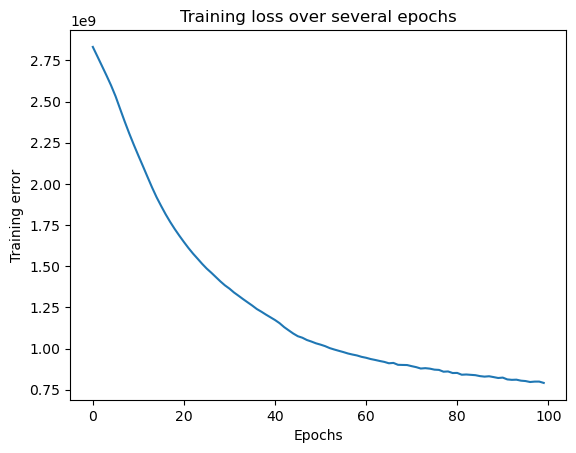

In [9]:
plt.plot(range(0, epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.title('Training loss over several epochs')
plt.show()